<a href="https://colab.research.google.com/github/KellieLeonard-Biostat/BreastcancerML/blob/main/EGFR_Gefitinib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade MDAnalysis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 3.8 MB/s eta 0:00:00


In [2]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis import rms

# Load the PDB files
wildtype = mda.Universe('2ity.pdb')  # Wildtype EGFR bound to Gefitinib
mutant = mda.Universe('2itz.pdb')    # EGFR L858R bound to Gefitinib

# Select common C-alpha atoms between wildtype and mutant
common_atoms_wildtype = wildtype.select_atoms('name CA and protein')
common_atoms_mutant = mutant.select_atoms('name CA and protein')

# Get the common residues using the intersection of residue IDs
common_residues = set(common_atoms_wildtype.residues.resids) & set(common_atoms_mutant.residues.resids)

# Select C-alpha atoms for the common residues
common_residues_wildtype = wildtype.select_atoms(f"name CA and resid {' '.join(map(str, common_residues))}")
common_residues_mutant = mutant.select_atoms(f"name CA and resid {' '.join(map(str, common_residues))}")

# Debugging: Check the number of C-alpha atoms in common residues
print(f"Number of common C-alpha atoms in Wildtype: {len(common_residues_wildtype)}")
print(f"Number of common C-alpha atoms in Mutant: {len(common_residues_mutant)}")

# Align the mutant structure to the wildtype structure using common residues
align.alignto(mutant, wildtype, select=f"name CA and resid {' '.join(map(str, common_residues))}")

# Calculate RMSD between the aligned C-alpha atoms
# Ensure the arrays are aligned correctly and positions are used in the correct order
rmsd_value = rms.rmsd(common_residues_mutant.positions, common_residues_wildtype.positions)

# Output the RMSD results
print(f"RMSD between wildtype and mutant structures: {rmsd_value} Å")


Number of common C-alpha atoms in Wildtype: 300
Number of common C-alpha atoms in Mutant: 300
RMSD between wildtype and mutant structures: 0.549190529376782 Å


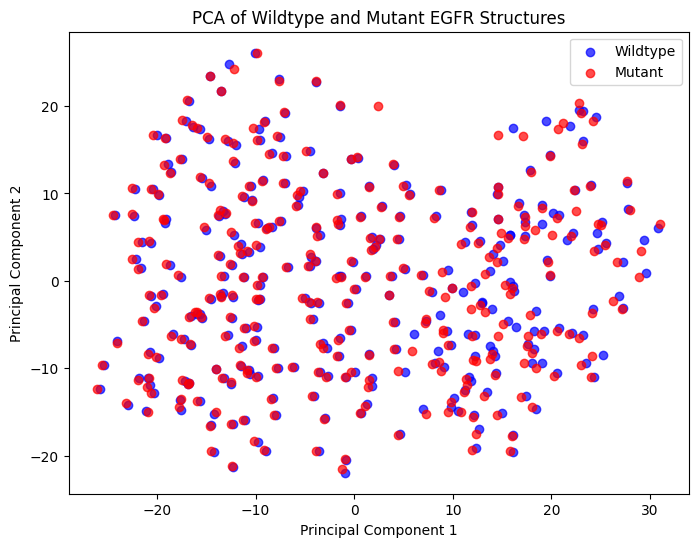

Explained Variance Ratio: [0.54769135 0.29121447]


In [3]:
import MDAnalysis as mda
from MDAnalysis.analysis import pca
import matplotlib.pyplot as plt

# Step 1: Load the PDB files
wildtype = mda.Universe('2ity.pdb')  # Wildtype EGFR bound to Gefitinib
mutant = mda.Universe('2itz.pdb')    # EGFR L858R bound to Gefitinib

# Step 2: Select the C-alpha atoms for PCA
wildtype_CA = wildtype.select_atoms('name CA and protein')
mutant_CA = mutant.select_atoms('name CA and protein')

# Combine the selections into one for PCA (you can concatenate if they are aligned, or you can perform PCA separately)
# Note: If you have a trajectory, you would loop through frames; here we work with one static frame per structure
coords_wildtype = wildtype_CA.positions
coords_mutant = mutant_CA.positions

# Step 3: Prepare the data for PCA
# You might want to center the coordinates (this will subtract the mean position)
# This will align both structures by removing the translational component
from sklearn.decomposition import PCA
import numpy as np

# Combine the structures into a matrix
all_coords = np.vstack([coords_wildtype, coords_mutant])

# Center the coordinates (subtract the mean of each atom's positions across both structures)
centered_coords = all_coords - np.mean(all_coords, axis=0)

# Step 4: Perform PCA
pca_model = PCA(n_components=2)  # We reduce to 2 components (you can use more)
pca_result = pca_model.fit_transform(centered_coords)

# Step 5: Visualize the PCA results (projection onto the first 2 principal components)

# Determine the number of C-alpha atoms in each structure
num_wildtype = coords_wildtype.shape[0]
num_mutant = coords_mutant.shape[0]

# Create a scatter plot with different colors for wildtype and mutant
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:num_wildtype, 0], pca_result[:num_wildtype, 1],
            c='blue', label='Wildtype', alpha=0.7)
plt.scatter(pca_result[num_wildtype:, 0], pca_result[num_wildtype:, 1],
            c='red', label='Mutant', alpha=0.7)

# Labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Wildtype and Mutant EGFR Structures')
plt.legend()

# Show the plot
plt.show()

# Output explained variance ratio
print(f"Explained Variance Ratio: {pca_model.explained_variance_ratio_}")



In [15]:
from scipy.spatial.distance import cdist
import numpy as np

# Get the PCA results for wildtype and mutant separately
wildtype_pca_result = pca_result[:num_wildtype]
mutant_pca_result = pca_result[num_wildtype:]

# Calculate Euclidean distance between wildtype and mutant PCA results
distance = cdist(wildtype_pca_result, mutant_pca_result, 'euclidean')

# Show average distance to quantify the separation
average_distance = np.mean(distance)
print(f'Average Euclidean distance between Wildtype and Mutant PCA scores: {average_distance:.2f}')

Average Euclidean distance between Wildtype and Mutant PCA scores: 22.86


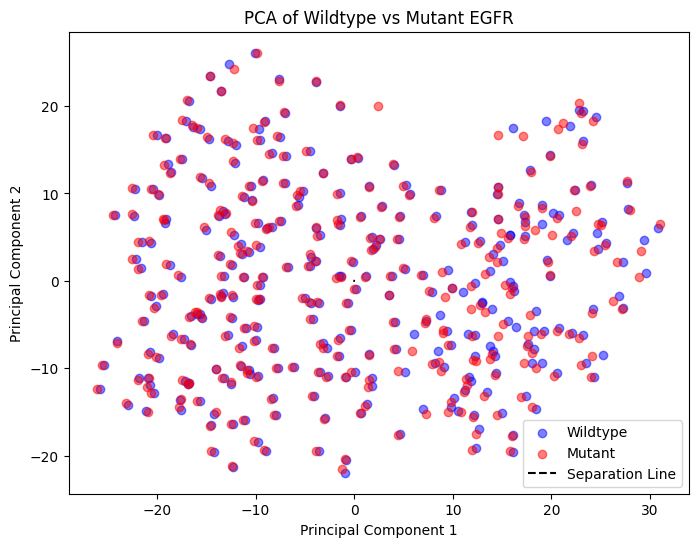

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Let's assume pca_wildtype and pca_mutant are already transformed PCA results
plt.figure(figsize=(8, 6))

# Plot the first two principal components for both wildtype and mutant
# Use wildtype_pca_result and mutant_pca_result, which contain PCA data
plt.scatter(wildtype_pca_result[:, 0], wildtype_pca_result[:, 1], label='Wildtype', color='blue', alpha=0.5)
plt.scatter(mutant_pca_result[:, 0], mutant_pca_result[:, 1], label='Mutant', color='red', alpha=0.5)

# Add Euclidean distance line to show separation
# Optional: You could calculate the centroid of the wildtype and mutant scores for the line
centroid_wt = np.mean(wildtype_pca_result, axis=0)
centroid_mut = np.mean(mutant_pca_result, axis=0)
plt.plot([centroid_wt[0], centroid_mut[0]], [centroid_wt[1], centroid_mut[1]], color="black", linestyle="--", label="Separation Line")

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Wildtype vs Mutant EGFR')
plt.legend()
plt.show()

Number of common C-alpha atoms in Wildtype: 300
Number of common C-alpha atoms in Mutant: 300


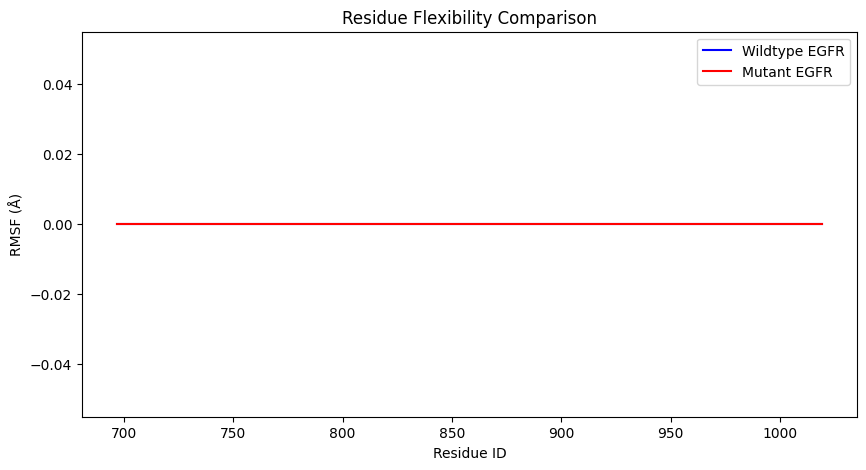

In [10]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.analysis.rms import RMSF

# Select common C-alpha atoms between wildtype and mutant
common_atoms_wildtype = wildtype.select_atoms('name CA and protein')
common_atoms_mutant = mutant.select_atoms('name CA and protein')

# Get the common residues using the intersection of residue IDs
common_residues = set(common_atoms_wildtype.residues.resids) & set(common_atoms_mutant.residues.resids)

# Select C-alpha atoms for the common residues
common_residues_wildtype = wildtype.select_atoms(f"name CA and resid {' '.join(map(str, common_residues))}")
common_residues_mutant = mutant.select_atoms(f"name CA and resid {' '.join(map(str, common_residues))}")

# Debugging: Check the number of C-alpha atoms in common residues
print(f"Number of common C-alpha atoms in Wildtype: {len(common_residues_wildtype)}")
print(f"Number of common C-alpha atoms in Mutant: {len(common_residues_mutant)}")

# Align the mutant structure to the wildtype structure using common residues
align.alignto(mutant, wildtype, select=f"name CA and resid {' '.join(map(str, common_residues))}")



# Compute RMSF for wildtype
rmsf_wildtype = RMSF(common_residues_wildtype).run()
rmsf_mutant = RMSF(common_residues_mutant).run()

# Plot RMSF
plt.figure(figsize=(10,5))

plt.plot(common_residues_wildtype.residues.resids, rmsf_wildtype.rmsf, label="Wildtype EGFR", color="blue") # Add a small offset
plt.plot(common_residues_mutant.residues.resids, rmsf_mutant.rmsf, label="Mutant EGFR", color="red")
plt.xlabel("Residue ID")
plt.ylabel("RMSF (Å)")
plt.legend()
plt.title("Residue Flexibility Comparison")
plt.show()
